## scikit-image for 3D image analysis
- 2022 skimage data umbrella workshop

*Import libraries*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import supplementary_code as sc

%matplotlib inline 
# Monospace font for figrures

plt.rcParams['font.family'] = 'monospace'

### skimage.io - Utilities to read/write images

- io.imread: read an image to a numpy array.
- io.imsave: write an image to disk.
- io.imread_collection: read multiple images which match a common pattern.


In [2]:
from skimage import io 
cells = io.imread('data/cells.tif')

In [3]:
print(f'cells shape: {cells.shape}')
print(f'cells type: {cells.dtype}')
print(f'cells range: {cells.min()}, {cells.max()}')

cells shape: (60, 256, 256)
cells type: float64
cells range: 0.0, 1.0


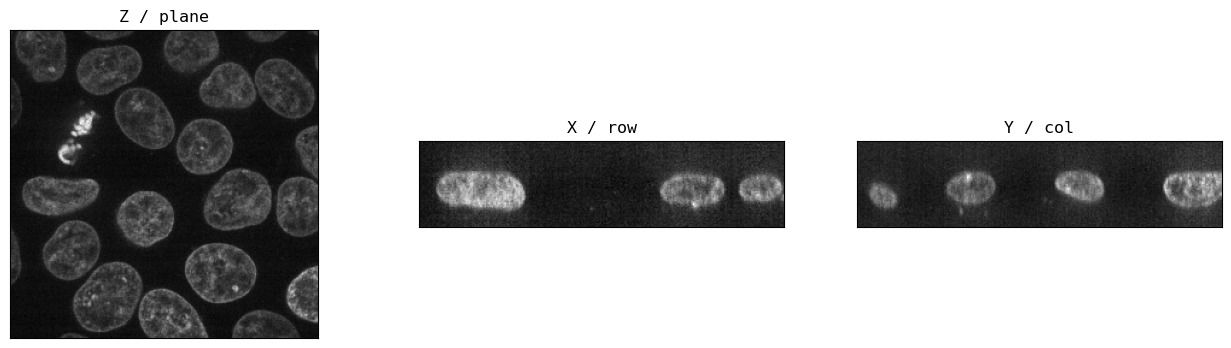

In [8]:
# Fix one axis, then observe three different views of img

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize = (16, 4))
sc.show_plane(win_left, cells[32], title = 'Z / plane')
sc.show_plane(win_center, cells[:, 128, :], title = 'X / row')
sc.show_plane(win_right, cells[:,:, 128], title = 'Y / col')

In [11]:
# interactive 2D slicer
sc.slice_explorer(cells)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

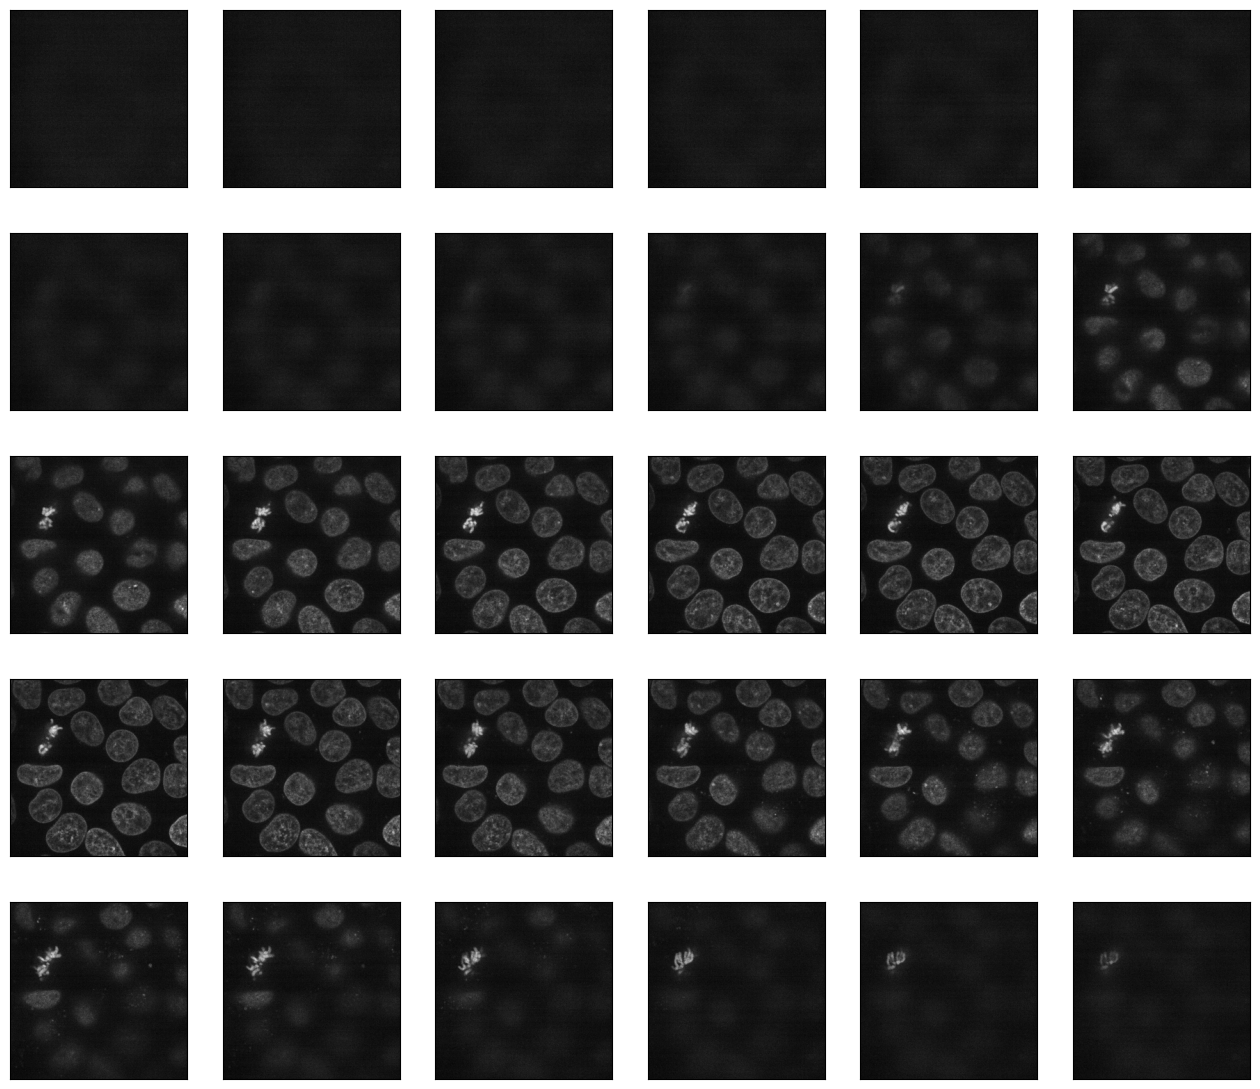

In [12]:
# Display snaps of all planes or Z slices
sc.display(cells)

### skimage.exposire - evaluating / changing the exposure of an image
- Module with multiple functions to change img contrast

In [13]:
from skimage import exposure

In [15]:
# Remove 0.5% of the darkest and brightest pixels to increase overall contrast of image
vmin, vmax = np.percentile(cells, q= (0.5, 99.5))
cells_rescaled = exposure.rescale_intensity(
    cells,
    in_range=(vmin, vmax),
    out_range=np.float32
)

sc.slice_explorer(cells_rescaled)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## Edge detection

- highlight regions in image where a sharp change in contrast happens
- intensity of an edge corresponds to the steepness of the transition of one intensity to another
- eg. 
    - dim edge: gradual shifft from bright to dark intensity
    - bright edge: abrupt shift 


### skimage.filters 

Testing with sobel filter # note sobel needs to be applied plane wise in 2d, no 3d:

In [19]:
from skimage import filters

cell_sobel = np.empty_like(cells_rescaled)

for z_plane, image in enumerate(cells_rescaled):
    cell_sobel[z_plane] = filters.sobel(image)

sc.slice_explorer(cell_sobel)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

### skimage.transform

- Reconstructing medical CT images use:
    - Radon (forward)
    - iradon (reverse)
    - iradon_sart
    - finite versions of above transforms, frt2 and ifrt2

- Identify lines, circles and ellipes:
    - Hough transforms

- Change image size, shape or resolution:
    - resize
    - rescale
    - downsample_local_mean

- Translate coordinates or image
    - warp_coordinates
    - warp
    - estimate_transform- parameter estimation

- Note panorama tutorial warping -Similarity transform with paramaeter estimation via measre.ransac

Text(0.5, 1.0, 'Downsampled: (32, 32)')

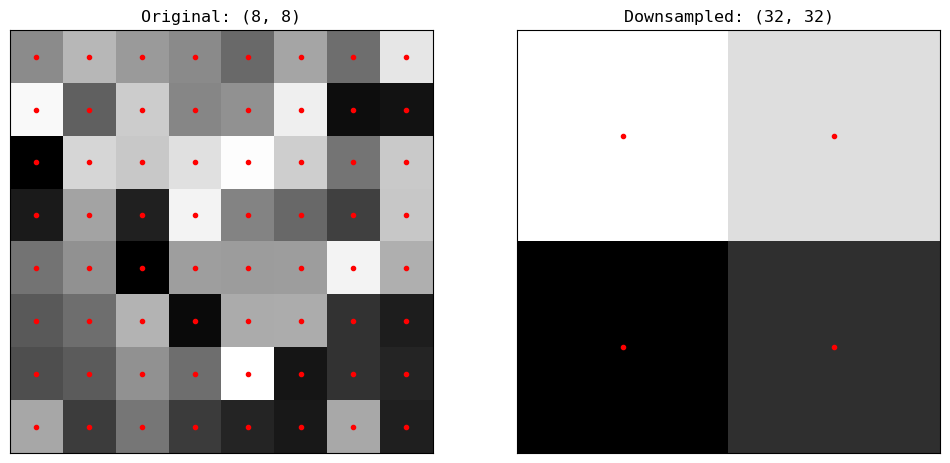

In [23]:
from skimage import transform

np.random.seed(0)

image = np.random.random((8,8))
image_rescaled = transform.downscale_local_mean(image, (4,4))

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

win_left.imshow(image, cmap='gray')
win_left.set_xticks([])
win_left.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
win_left.plot(centers[:, 0], centers[:, 1], '.r')
win_left.set_title(f'Original: {image.shape}')

win_right.imshow(image_rescaled, cmap='gray')
win_right.set_xticks([])
win_right.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
win_right.plot(centers[:, 0], centers[:, 1], '.r');
win_right.set_title(f'Downsampled: {image_rescaled.shape}')


### Spacing:

- distance between pixels in each dimension
- encoded as a tuple
- Spacing reported by microscope 
- can be accepted as a parameter by some skimage functions and adjust contributions to filter, and help decide when to apply operations planewise
- Above we downsampled by a factor of 4 in the row and column to make data smaller, and also normalise it to 1.0 in the row and column dimensions 

In [24]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print(f'* Microscope original spacing: {original_spacing}')

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print(f'* Microscope after rescaling images: {rescaled_spacing}')

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print(f'* Microscope normalized spacing: {spacing}')


* Microscope original spacing: [0.29  0.065 0.065]
* Microscope after rescaling images: [0.29 0.26 0.26]
* Microscope normalized spacing: [1.11538462 1.         1.        ]


## Filters

- Median filter (not 3d, apply planewise) removes noise. 
- Effective for salt and pepper noise. 
- It also preserves edges.
- Helpful segmentation because original shape for ROI is preserved

### skimage.util

Example useful functions
- util.img_as_*  - are convenience functions for datatype conversion
- util.invert - to invert any image, accounting for its datatype
- util.random_noise - apply x amount of noise to images. set seed, get pseudo-random noise fpr testing
- util.view_as_* - allows for overlapping views into same memory array, minimising memory impact
- util.apply_parallel - Uses Dask to apply a function across subsections of image
- util.pad and util crop
 

In [25]:
from skimage import util